Polar Sat: [7.2567519e+06 1.0000000e+00 3.0000000e-01]
Cartesian 2D Sat: [3920839.784683   6106346.16779957]
{'distance': 893775.8345085649, 'x': 3439944.101247551, 'y': 5352970.707617449, 'error': 5.818213134454842e-09, 'iterations': 2, 'success': True, 'xs': array([1.00115065, 1.00115064]), 'errors': array([1.15065078e-03, 5.81821313e-09])}
893775.8345085649


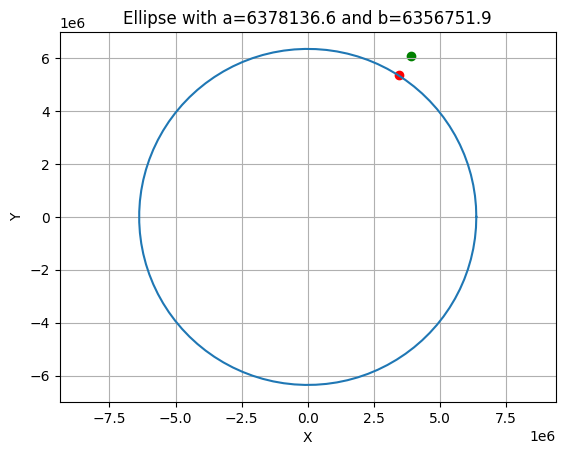

In [1]:
import utilities as ut
from Earth import Earth
from Filter import LinearKalmanFilter
import numpy as np
import matplotlib.pyplot as plt

'''
EARTH TESTING -- DONE 
'''

E = Earth()

dummy_sat_pos = np.array([E.rp + 900000, 1, 0.3])

print(f"Polar Sat: {dummy_sat_pos}")

xy_pos = ut.p_to_c([dummy_sat_pos[0], dummy_sat_pos[1]])
print(f"Cartesian 2D Sat: {xy_pos}")

res = E.distane_to_surface(dummy_sat_pos)
print(res)

# Parameters of the ellipse
a = E.re  # semi-major axis
b = E.rp  # semi-minor axis

# Generate angles from 0 to 2*pi
theta = np.linspace(0, 2*np.pi, 100)

# Parametric equations for the ellipse
x = a * np.cos(theta)
y = b * np.sin(theta)

# Plot the ellipse
plt.figure()

plt.plot(x, y)
opt_x = res['x']
opt_y = res['y']

distance = np.sqrt((xy_pos[0] - opt_x)**2 + (xy_pos[1] - opt_y)**2)
print(distance)

plt.scatter(opt_x, opt_y, color='red')
plt.scatter(xy_pos[0], xy_pos[1], color="green")


plt.xlabel('X')
plt.ylabel('Y')
plt.title('Ellipse with a={} and b={}'.format(a, b))
plt.axis('equal')
plt.grid(True)
plt.show()


In [2]:
'''
KALMAN FILTER TESTING
'''
#Start with agnostic state.
m0 = np.array([E.re + 700000, 10, 100, -2000, 2, 2])

C0 = 100.0 * np.eye(6) 
#print(m0)

H = np.array([
    [1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 1, 0],
])

delta_t = 10  # Example time step, you should replace this with your actual time step

F = np.array([
    [1, 0, 0, delta_t, 0, 0],
    [0, 1, 0, 0, delta_t, 0],
    [0, 0, 1, 0, 0, delta_t],
    [0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1]
])

R = 10*np.eye(3)

Q = np.eye(6) 


LKF = LinearKalmanFilter(mean_0=m0, cov_0=C0, transition_matrix=F, 
                         observation_matrix=H, observation_noise=R, process_noise=Q)

m0_true = np.array([E.re + 600000, 1, 0, -100, 1, 0])
m0_true = m0_true[:, np.newaxis]
True_States = []
Predicted_States = []

[6977202.6113073]


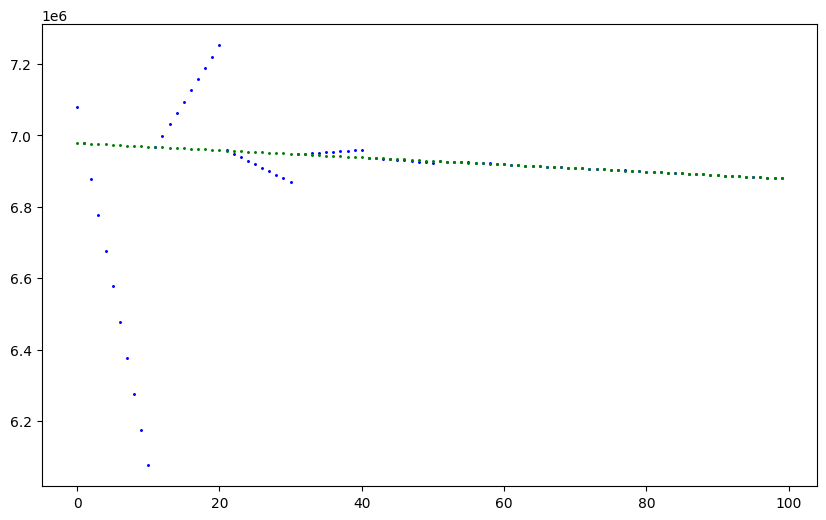

In [3]:
for i in range(100):
    True_States.append(m0_true)
    Predicted_States.append(LKF.m)

    #update truth
    m0_true = F @ m0_true 

    #forecast KALMAN 
    LKF.forecast()

    #How often data is sent
    if i % 10 == 0 or i == 0:
        #make synthetic noisy data
        y = (LKF.H @ m0_true) + 10* np.random.normal(0, 1)
        #update KALMAN
        K = LKF.get_kalman_gain()

        LKF.update(y)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

print(Predicted_States[1][0])
for i in range(100):
    ax.scatter(i, Predicted_States[i][0], s=5, c='b', marker='.')
    ax.scatter(i, True_States[i][0], s=5, c='g', marker='.')
plt.show()


In [ ]:
from Filter import ExtendedKalmanFilter

#Start with agnostic state.
m0 = np.array([E.re + 700000, 10, 100, -2000, 2, 2])

C0 = 100.0 * np.eye(6) 

R = 10*np.eye(3)

Q = 1*np.eye(6)

EKF = ExtendedKalmanFilter(mean_0=m0, cov_0=C0, planet=E, observation_matrix=None, observation_noise=R, process_noise=Q)


In [ ]:
m0_true = np.array([E.re + 600000, 1, 0, -100, 1, 0])
m0_true = m0_true[:, np.newaxis]
True_States = []
Predicted_States = []

for i in range(100):
    True_States.append(m0_true)
    Predicted_States.append(EKF.m)

    #update truth
    m0_true = F @ m0_true 

    #forecast KALMAN 
    LKF.forecast()

    #How often data is sent
    if i % 10 == 0 or i == 0:
        #make synthetic noisy data
        y = (LKF.H @ m0_true) + 10* np.random.normal(0, 1)
        #update KALMAN
        K = LKF.get_kalman_gain()

        LKF.update(y)


fig, ax = plt.subplots(1, 1, figsize=(10, 6))

print(Predicted_States[1][0])
for i in range(100):
    ax.scatter(i, Predicted_States[i][0], s=5, c='b', marker='.')
    ax.scatter(i, True_States[i][0], s=5, c='g', marker='.')
plt.show()
